In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
from math import inf


 

In [3]:
def draw_graph(G,pos):

    Rs = [G[u][v]['R'] for u,v in G.edges()]
    max_R = max(Rs)

    weights = [i*8/max_R for i in Rs]

    colors = ['r','g','b','pink','purple','black','yellow','grey','orange']
    cc=[]
    for i in range(len(Rs)):
        n = len(colors)
        x = random.randint(0,n-1)
        cc.append(colors[x])

    edge_labels = dict([((n1, n2), round(Rs[i],2))
                    for i, (n1, n2) in enumerate(G.edges)])

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edges(G, pos)
    nx.draw(G,pos, width=weights,edge_color=cc,node_color='lightgreen', node_size=15)

In [4]:


def analysis(G, s, t, E, pos):
     
    if not G.has_edge(s,t):
        G.add_edge(s,t, R=0)


    if not nx.is_weakly_connected(G.to_directed()):
        raise Exception("graph is not connected")

    if not (s in G.nodes() and t in G.nodes()):
        raise Exception('Voltage applied to invalid nodes')

    n = G.number_of_edges()
    A = np.zeros((n,n))
    B = np.zeros(n)

    cycles = nx.cycle_basis(G)

    edges = list(G.edges())
    
    nodes = list(G.nodes())

    node = nodes[0]
    i = 0
    numOfEq = 0

    #2nd Kirchoffs law
    for cycle in cycles:
        
        for j in range(len(cycle)):
            if j < len(cycle)-1:
                 edge = (cycle[j], cycle[j+1])
            else:
                 edge = (cycle[j], cycle[0])

            if edge == (s, t):
                B[numOfEq] = E
            elif edge == (t, s):
                B[numOfEq] = -E
            
            else:
                (u, v) = edge
                if edge in edges:
                    j = edges.index((u,v))
                    A[numOfEq,j] = G.get_edge_data(u,v)['R']
                else: 
                    j = edges.index((v,u))
                    A[numOfEq,j] = -G.get_edge_data(v,u)['R']
        numOfEq += 1
        if numOfEq>=n:
            break


    #1st Kirchoffs law
    while i < G.number_of_nodes()-1:
        for edge in G.edges(node):
            sign = 1
            (u, v) = edge
            if edge not in edges:
                sign = -1
                (u,v) = edge[1], edge[0]
            j = edges.index((u,v))
            A[numOfEq, j] = sign
        numOfEq += 1
        i += 1
        node = nodes[i]
        if numOfEq>=n:
            break
    
    
    res = np.linalg.solve(A,B)

    def buildSolution():   

        solution = nx.DiGraph()
        for i, (u,v) in enumerate(edges):

            intensity = res[i]
            abc = abs(res[i])
            if intensity>0:
                solution.add_edge(u,v,R=abc)
            else:
                solution.add_edge(v,u,R=abc)

        return solution

    solution = buildSolution()

    def checkSolution(G):   
        edges = list(G.edges())
        for node in G.nodes():
            I = 0
            for (u,v) in G.in_edges(node):
                I += G.get_edge_data(u,v)['R']
            for (u,v) in G.out_edges(node):
                I -= G.get_edge_data(u,v)['R']
            if I > 1e-6:
                raise Exception("Solution does not meet Kirchoffs 1st law")
        

    if len(edges) < 50 or type(node) != type('int'):
        draw_graph(solution,pos)

    checkSolution(solution)


    return solution







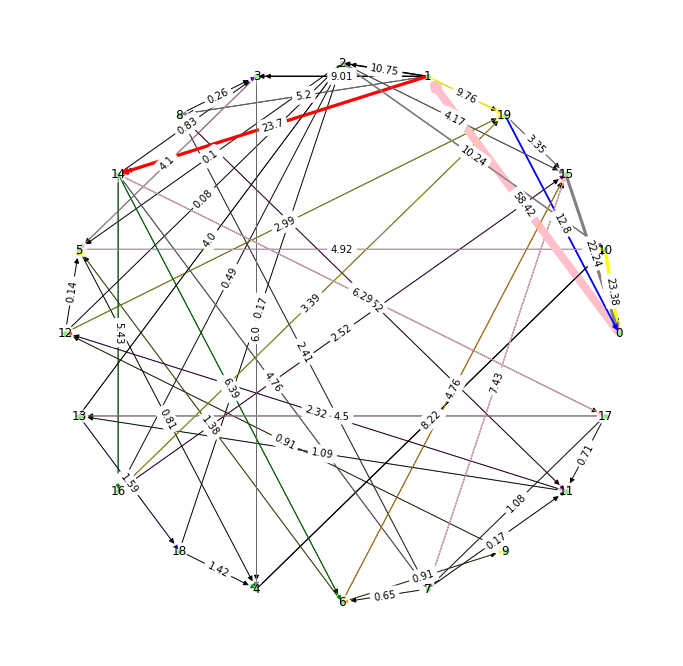

In [5]:
#simple connected graph

def gen_graph(n):
    G = nx.Graph()
    for u in range(n):
        for v in range(u+1, n):
            if random.random() < 0.22:
                R = random.randint(1, 5)

                G.add_edge(u, v, R=R)

    return G


n = 20

s, t = 0, 1
E = 100
G = gen_graph(n)
pos = nx.circular_layout(G) 
plt.figure(figsize = (12, 12))

res = analysis(G, s, t, E, pos)


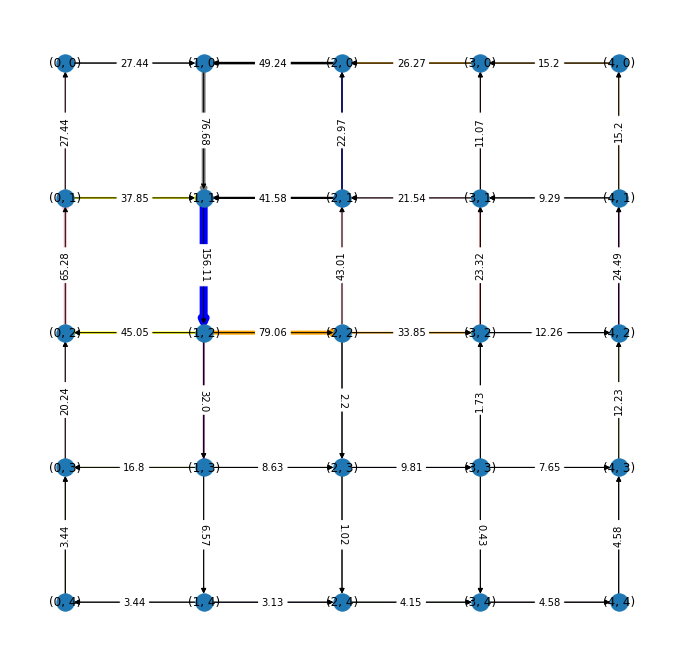

In [6]:

#2d 

n = 5
G = nx.Graph()
for u, v in nx.grid_2d_graph(n, n).edges():
    R = random.randint(1,10)
    G.add_edge(u, v, R=R)

G = G.to_undirected()

E = 1000
s, t = (1, 1), (1, 2)
G.add_edge(s,t,R=E)

pos = {
    (i, j): [i, -j]
    for i in range(G.number_of_nodes())
    for j in range(G.number_of_nodes())
}
plt.figure(figsize = (12, 12))

res = analysis(G,s,t,E,pos)

nx.draw(res,pos)

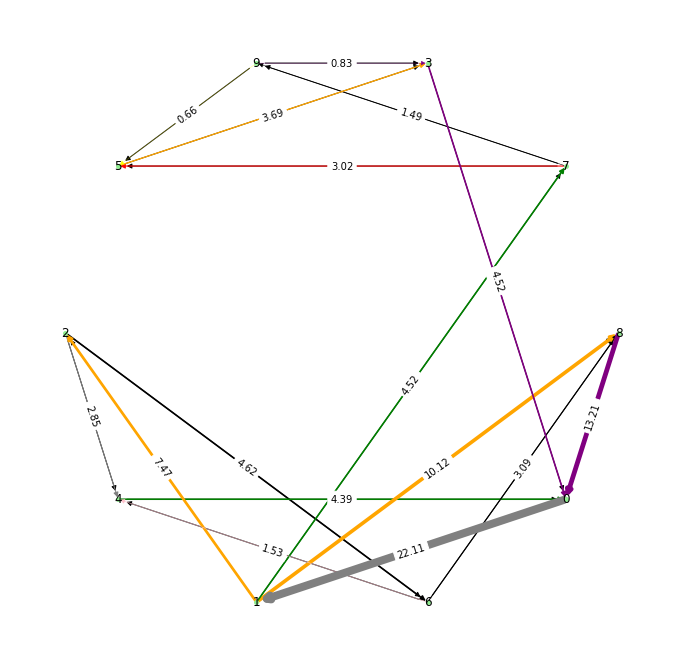

In [7]:
n = 10
d = 3

TMP = nx.random_regular_graph(d, n)

G = nx.Graph()
for u,v in TMP.edges():
    R = random.randint(1,10)
    G.add_edge(u, v, R=R)


pos = nx.shell_layout(G)
s=0
t=1
E = 70
plt.figure(figsize = (12, 12))

res = analysis(G,s,t,E,pos)

In [33]:
#graphs with brigde
plt.figure(figsize = (12, 12))
n=15
G = gen_graph(n)
X = gen_graph(n)
E = 420
s = 0
t = 1
C = nx.compose(G,X)
C.add_edge(0, n)



res = analysis(C,s,t,E,pos, draw=False)
pos = nx.shell_layout(res)

draw_graph(res,pos)

TypeError: analysis() got an unexpected keyword argument 'draw'

<Figure size 864x864 with 0 Axes>

In [ ]:
#small world graph


G = nx.watts_strogatz_graph(n = 10, m = 4, p = 0.5)
pos = nx.circular_layout()


s = 3
t = 10


